In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 134443 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.17-0ubuntu2~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.chdir('drive/Internshala_assignment')

In [0]:
ls

 glove.6B.100d1.txt   glove.6B.zip        imdb-dataset-of-50k-movie-reviews.zip
 glove.6B.100d.txt   'IMDB Dataset.csv'   Untitled0.ipynb


In [0]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

In [0]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


Import and analyze the dataset

In [0]:
movie_reviews = pd.read_csv("IMDB Dataset.csv")
movie_reviews.isnull().values.any()
movie_reviews.shape

(50000, 2)

In [0]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Here as we see there are two classes of sentiment *positive* & *negative*. Let's examine their distribution over training set.

In [0]:
movie_reviews["review"][5]

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

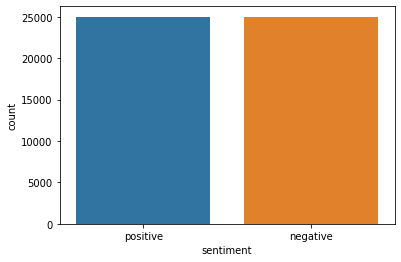

In [0]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

**Data Preprocessing **

In [0]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [0]:
def preprocess_text(sen):
    sentence = remove_tags(sen)     # Removing html tags
    sentence = re.sub('[^a-zA-Z]', ' ', sentence) # Remove punctuations and numbers
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)   # Single character removal
    sentence = re.sub(r'\s+', ' ', sentence)  # Removing multiple spaces

    return sentence

In [0]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [0]:
X[5]

'Probably my all time favorite movie story of selflessness sacrifice and dedication to noble cause but it not preachy or boring It just never gets old despite my having seen it some or more times in the last years Paul Lukas performance brings tears to my eyes and Bette Davis in one of her very few truly sympathetic roles is delight The kids are as grandma says more like dressed up midgets than children but that only makes them more fun to watch And the mother slow awakening to what happening in the world and under her own roof is believable and startling If had dozen thumbs they all be up for this movie '

Now convert positive & negative sentiments into binary digits

In [0]:
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [0]:
#divide the dataset into training and test set in 80% and 20% respectively 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Convert the textual data into numeric 

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [0]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-02-23 06:53:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-02-23 06:53:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-02-23 06:53:28--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [0]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Text Classification using simple Neural Network

In [0]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [0]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)



Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 1s 40us/step - loss: 0.6040 - acc: 0.6699 - val_loss: 0.5383 - val_acc: 0.7318
Epoch 2/6
32000/32000 [==============================] - 1s 30us/step - loss: 0.5022 - acc: 0.7573 - val_loss: 0.5188 - val_acc: 0.7428
Epoch 3/6
32000/32000 [==============================] - 1s 29us/step - loss: 0.4598 - acc: 0.7845 - val_loss: 0.5190 - val_acc: 0.7415
Epoch 4/6
32000/32000 [==============================] - 1s 28us/step - loss: 0.4443 - acc: 0.7924 - val_loss: 0.5221 - val_acc: 0.7448
Epoch 5/6
32000/32000 [==============================] - 1s 28us/step - loss: 0.4223 - acc: 0.8063 - val_loss: 0.5274 - val_acc: 0.7426
Epoch 6/6
32000/32000 [==============================] - 1s 29us/step - loss: 0.4101 - acc: 0.8148 - val_loss: 0.5346 - val_acc: 0.7421


In [0]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

10000/10000 [==============================] - 0s 42us/step
Test Score: 0.5355375527858734
Test Accuracy: 0.7444


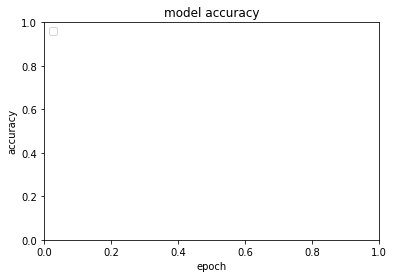

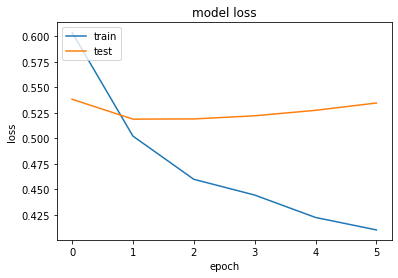

In [0]:
import matplotlib.pyplot as plt
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

Text Classification using Conv Net

In [0]:
!pip install seq2seq-lstm

  Created wheel for seq2seq-lstm: filename=seq2seq_lstm-0.1.4-cp36-none-any.whl size=14626 sha256=4a918909e01d7cc16e9a1e49f6f42832e144dedc537daebb9b2b1ecd4ccf45f9
  Stored in directory: /root/.cache/pip/wheels/22/fb/c9/c48f5b1e28e2ee101b3880f8a472d8f85f5681dac84449aedb
Successfully built seq2seq-lstm


In [0]:
from keras.layers.recurrent import LSTM

In [0]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [0]:
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [0]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 81s 3ms/step - loss: 0.5510 - acc: 0.7163 - val_loss: 0.4528 - val_acc: 0.7909
Epoch 2/6
32000/32000 [==============================] - 80s 2ms/step - loss: 0.4432 - acc: 0.7937 - val_loss: 0.4235 - val_acc: 0.8027
Epoch 3/6
32000/32000 [==============================] - 79s 2ms/step - loss: 0.3877 - acc: 0.8237 - val_loss: 0.3731 - val_acc: 0.8317
Epoch 4/6
32000/32000 [==============================] - 80s 2ms/step - loss: 0.3598 - acc: 0.8405 - val_loss: 0.3647 - val_acc: 0.8400
Epoch 5/6
32000/32000 [==============================] - 80s 2ms/step - loss: 0.3397 - acc: 0.8507 - val_loss: 0.3542 - val_acc: 0.8445
Epoch 6/6
10000/10000 [==============================] - 9s 918us/step
Test Score: 0.34938472797870634
Test Accuracy: 0.8496


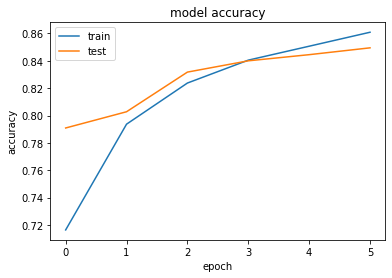

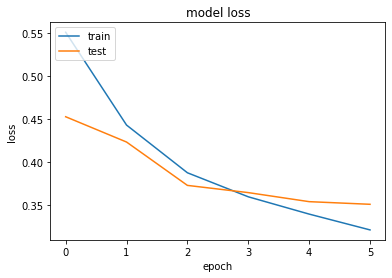

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [0]:
instance = X[57]
print(instance)

I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned 


In [0]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.81876993]], dtype=float32)

# The value that we get is greater that 0.5 that means the selected text is of positive sentiment as predicted.